/var/folders/vc/mm20ljdj4hx70_c_bgr3q0540000gn/T/ipykernel_18494/3407870779.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 2, 1)


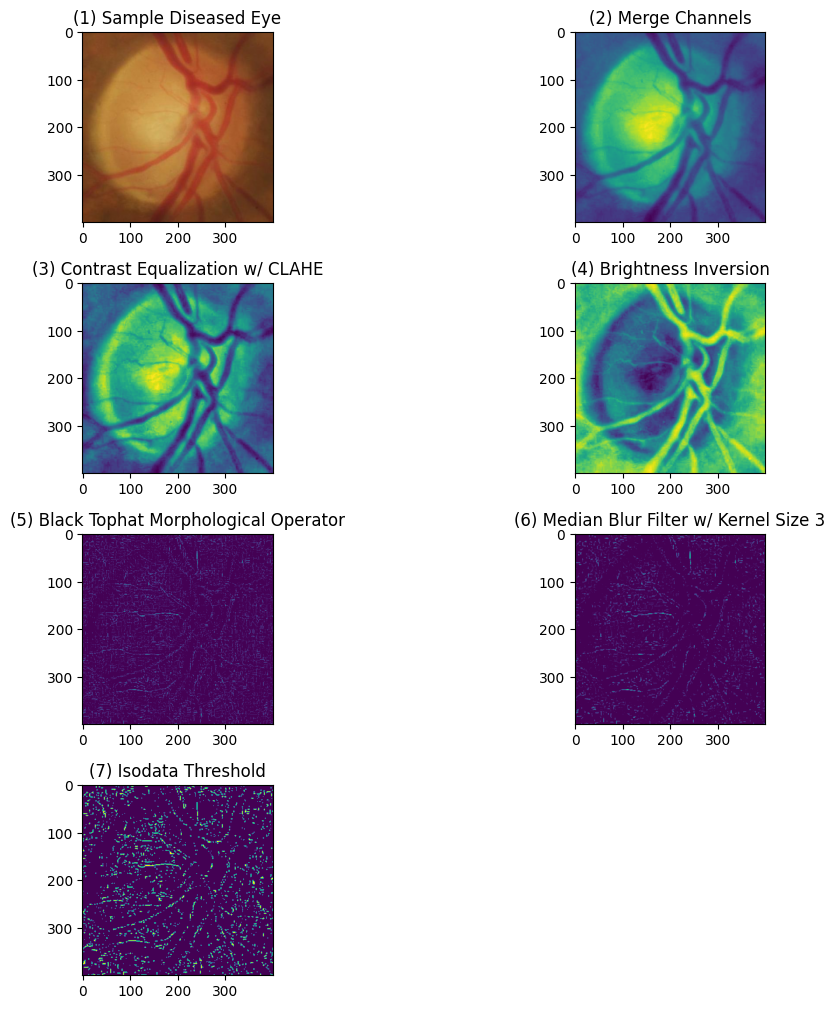

In [25]:
# In this cell, we 
# - convert original image to grayscale
# - equalize contrast with CLAHE algorithm to increase grayscale vessel separation
# - use median blur filter to decrease noise while preserving edges
# - use isodata threshold algorithm to obtain final binarized image of segmented vessels

from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import io
from skimage import filters
from skimage import morphology
from skimage import exposure
from skimage import transform
import numpy as np
import cv2

plt.figure(figsize=(10, 20))

img = io.imread("diseased5.png")
img = transform.resize(img, (400, 400))
io.imshow(img)
plt.subplot(8, 2, 1)

# Display sample image
plt.title("(1) Sample Diseased Eye")
plt.imshow(img)

# Convert RGB image to monochrome
# gray_img = rgb2gray(img)
# plt.subplot(8, 2, 2)
# plt.title("(2) Monochrome Conversion")
# plt.imshow(gray_img, cmap="gray")

# Extract Green Channel from Image
b, g, r = cv2.split(cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB))
green_img = g
plt.subplot(8, 2, 2)
plt.title("(2) Merge Channels")
plt.imshow(green_img)

# Equalize contrast with CLAHE algorithm - Contrast Limited Adaptive Histogram Equalization
# (Uses histrograms computed over different tile regions to enhance local details irregardless of brightness)
clahe_img = exposure.equalize_adapthist(green_img)
plt.subplot(8, 2, 3)
plt.title("(3) Contrast Equalization w/ CLAHE")
plt.imshow(clahe_img)

# Invert Image Brightness
inverted_img = (255 - clahe_img) / 255
plt.subplot(8, 2, 4)
plt.title("(4) Brightness Inversion")
plt.imshow(inverted_img)

# Black tophat morphological operator on green channel
tophat_img = morphology.black_tophat(clahe_img)
plt.subplot(8, 2, 5)
plt.title("(5) Black Tophat Morphological Operator")
plt.imshow(tophat_img)

# Denoise image with the median blur filter
denoised_img = cv2.medianBlur(np.float32(tophat_img), 3)
plt.subplot(8, 2, 6)
plt.title("(6) Median Blur Filter w/ Kernel Size 3")
plt.imshow(denoised_img)

# Use isodata thresholding algorithm to produce binarized image
threshold = filters.threshold_isodata(denoised_img)
binary_img = denoised_img > threshold
plt.subplot(8, 2, 7)
plt.title("(7) Isodata Threshold")
plt.imshow(binary_img)

plt.tight_layout()

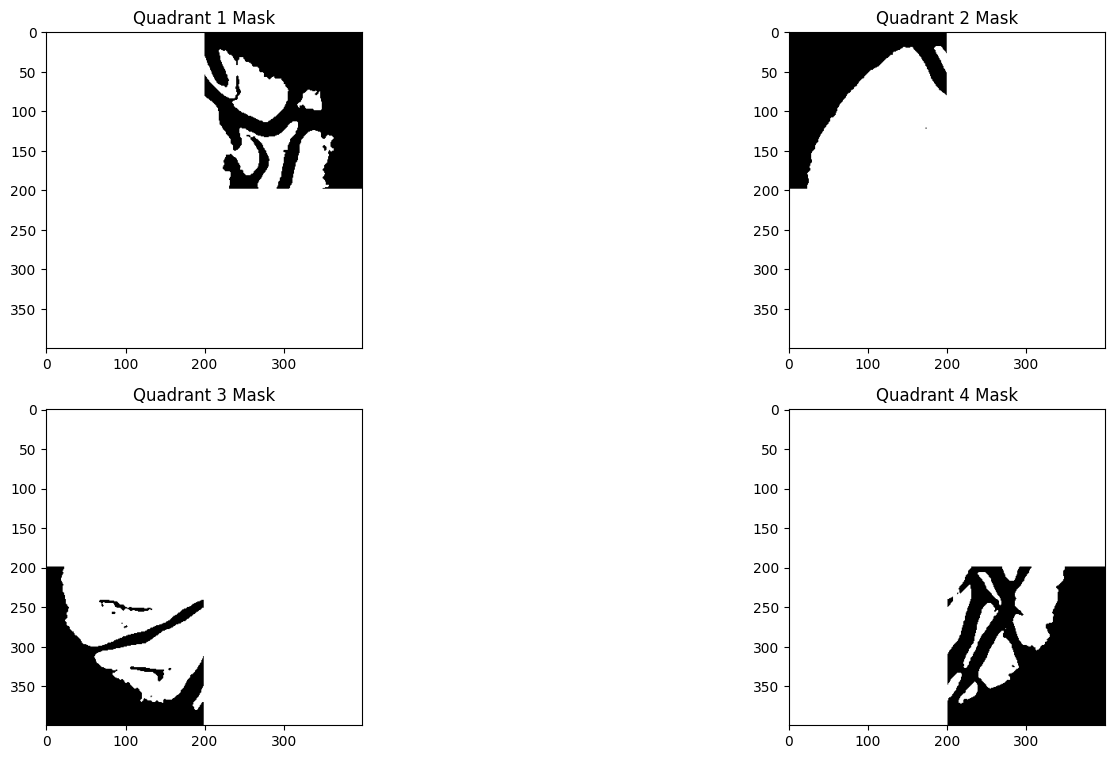

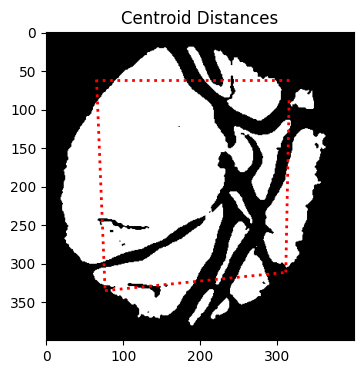

Centroid Distance Values:
251.25070257948568
274.34779253674344
235.86403092264095
226.6093694990287

Mean Distance:
247.01797388447469


In [22]:
# In this cell, we 
# - use hard-coded quadrant masks to divide image into quandrants with "+" shape
# - calculate vessel centroid for each quadrant
# - calculate distance between centroids as a feature
# (greater distance between centroids => thinned NRR => glaucoma is probable)

from skimage import draw
from skimage import img_as_float
import math
import statistics

def findCentroid(img):
    # Calculate centroid (vp = vessel pixel)
    vpTotal = 0
    vpX = 0
    vpY = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 0:
                vpTotal += 1
                vpX += i
                vpY += j

    return [(vpX / vpTotal), (vpY / vpTotal)]

right = binary_img.shape[0] - 1
bottom = binary_img.shape[1] - 1
corner1 = [0, 0]
corner2 = [0, bottom]
corner3 = [right, 0]
corner4 = [right, bottom]
midbottom = [int(right / 2), bottom]
midtop = [int(right / 2), 0]
midleft = [0, int(bottom / 2)]
midright = [right, int(bottom / 2)]
midpoint = [int(right / 2), int(bottom / 2)]

plt.figure(figsize=(15, 15))

# 1st quadrant
polygon = draw.polygon((corner1[1], midtop[1], midpoint[1], midright[1], corner4[1], corner2[1]), 
                       (corner1[0], midtop[0], midpoint[0], midright[0], corner4[0], corner2[0]))
quadrant1 = binary_img.copy()
draw.set_color(quadrant1, polygon, 1)
plt.subplot(4, 2, 1)
plt.title("Quadrant 1 Mask")
plt.imshow(quadrant1, cmap="gray")

# 2nd quadrant
polygon = draw.polygon((midleft[1], midpoint[1], midtop[1], corner3[1], corner4[1], corner2[1]), 
                       (midleft[0], midpoint[0], midtop[0], corner3[0], corner4[0], corner2[0]))
quadrant2 = binary_img.copy()
draw.set_color(quadrant2, polygon, 1)
plt.subplot(4, 2, 2)
plt.title("Quadrant 2 Mask")
plt.imshow(quadrant2, cmap="gray")

# 3rd quadrant
polygon = draw.polygon((midbottom[1], midpoint[1], midleft[1], corner1[1], corner3[1], corner4[1]), 
                       (midbottom[0], midpoint[0], midleft[0], corner1[0], corner3[0], corner4[0]))
quadrant3 = binary_img.copy()
draw.set_color(quadrant3, polygon, 1)
plt.subplot(4, 2, 3)
plt.title("Quadrant 3 Mask")
plt.imshow(quadrant3, cmap="gray")

# 4th quadrant
polygon = draw.polygon((midright[1], midpoint[1], midbottom[1], corner2[1], corner1[1], corner3[1]), 
                       (midright[0], midpoint[0], midbottom[0], corner2[0], corner1[0], corner3[0]))
quadrant4 = binary_img.copy()
draw.set_color(quadrant4, polygon, 1)
plt.subplot(4, 2, 4)
plt.title("Quadrant 4 Mask")
plt.imshow(quadrant4, cmap="gray")

plt.tight_layout()

# Find and show distances btwn centroids
centroid1 = findCentroid(quadrant1)
centroid2 = findCentroid(quadrant2)
centroid3 = findCentroid(quadrant3)
centroid4 = findCentroid(quadrant4)
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plt.title("Centroid Distances")
plt.plot([centroid1[1], centroid2[1]], [centroid2[0], centroid2[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid2[1], centroid3[1]], [centroid2[0], centroid3[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid3[1], centroid4[1]], [centroid3[0], centroid4[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid4[1], centroid1[1]], [centroid4[0], centroid1[0]], ls="dotted", color="red", linewidth=2)
plt.imshow(binary_img, cmap="gray")
plt.show()

# calculate and average the distances of centroids
distances = []
distances.append(math.dist(centroid1, centroid2))
distances.append(math.dist(centroid2, centroid3))
distances.append(math.dist(centroid3, centroid4))
distances.append(math.dist(centroid4, centroid1))
print("Centroid Distance Values:")
for d in distances:
    print(d)
print()
print("Mean Distance:")
print(statistics.mean(distances))

In [23]:
# Now, lets test our hypothesis that greater mean centroid distance indicates glaucoma using "+" shaped mask:
# 5 diseased eyes, 5 healthy eyes

from skimage import color, io, filters, morphology, exposure, draw, img_as_float, transform
import numpy as np
import cv2
import math
import statistics

# To minimize code, we can encapsulate what we have done inside a function to do it over and over
def meanCentroidDistanceFromRaw(imgSource):
    # Preprocessing / Vessel Segmentation
    img = io.imread(imgSource)
    img = transform.resize(img, (400, 400))
    gray_img = rgb2gray(img) # Convert RGB image to monochrome
    clahe_img = exposure.equalize_adapthist(gray_img) # Equalize contrast with CLAHE algorithm
    denoised_img = cv2.medianBlur(np.float32(clahe_img), 3) # Denoise image with the median blur filter
    threshold = filters.threshold_isodata(denoised_img) # obtain threshold with isodata algorithm
    binary_img = denoised_img > threshold # binarize image
    
    # Get Quadrant Mask Points
    right = binary_img.shape[0] - 1
    bottom = binary_img.shape[1] - 1
    corner1 = [0, 0]
    corner2 = [0, bottom]
    corner3 = [right, 0]
    corner4 = [right, bottom]
    midbottom = [int(right / 2), bottom]
    midtop = [int(right / 2), 0]
    midleft = [0, int(bottom / 2)]
    midright = [right, int(bottom / 2)]
    midpoint = [int(right / 2), int(bottom / 2)]

    # Quadrant Masks
    polygon = draw.polygon((corner1[1], midtop[1], midpoint[1], midright[1], corner4[1], corner2[1]), 
                           (corner1[0], midtop[0], midpoint[0], midright[0], corner4[0], corner2[0]))
    quadrant1 = binary_img.copy()
    draw.set_color(quadrant1, polygon, 1)
    polygon = draw.polygon((midleft[1], midpoint[1], midtop[1], corner3[1], corner4[1], corner2[1]), 
                           (midleft[0], midpoint[0], midtop[0], corner3[0], corner4[0], corner2[0]))
    quadrant2 = binary_img.copy()
    draw.set_color(quadrant2, polygon, 1)
    polygon = draw.polygon((midbottom[1], midpoint[1], midleft[1], corner1[1], corner3[1], corner4[1]), 
                           (midbottom[0], midpoint[0], midleft[0], corner1[0], corner3[0], corner4[0]))
    quadrant3 = binary_img.copy()
    draw.set_color(quadrant3, polygon, 1)
    polygon = draw.polygon((midright[1], midpoint[1], midbottom[1], corner2[1], corner1[1], corner3[1]), 
                           (midright[0], midpoint[0], midbottom[0], corner2[0], corner1[0], corner3[0]))
    quadrant4 = binary_img.copy()
    draw.set_color(quadrant4, polygon, 1)

    # Find centroids
    def findCentroid(img):
        # Calculate centroid (vp = vessel pixel)
        vpTotal = 0
        vpX = 0
        vpY = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    vpTotal += 1
                    vpX += i
                    vpY += j

        return [(vpX / vpTotal), (vpY / vpTotal)]
    
    centroid1 = findCentroid(quadrant1)
    centroid2 = findCentroid(quadrant2)
    centroid3 = findCentroid(quadrant3)
    centroid4 = findCentroid(quadrant4)
    
#     plt.figure(figsize=(4, 4))
#     plt.subplot(1, 1, 1)
#     plt.title(imgSource + " Centroid Distances")
#     plt.plot([centroid1[1], centroid2[1]], [centroid2[0], centroid2[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid2[1], centroid3[1]], [centroid2[0], centroid3[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid3[1], centroid4[1]], [centroid3[0], centroid4[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid4[1], centroid1[1]], [centroid4[0], centroid1[0]], ls="dotted", color="red", linewidth=2)
#     plt.imshow(binary_img, cmap="gray")
#     plt.show()

    # Centroid Distance Calculation
    distances = []
    distances.append(math.dist(centroid1, centroid2))
    distances.append(math.dist(centroid2, centroid3))
    distances.append(math.dist(centroid3, centroid4))
    distances.append(math.dist(centroid4, centroid1))
    
    res = round(statistics.mean(distances), 3)
    print(res, end=", ")
    
    return res

imagesDiseased = []
imagesHealthy = []
for i in range(1, 6):
    imagesDiseased.append("diseased" + str(i) + ".png")
    imagesHealthy.append("healthy" + str(i) + ".png")
    
# Diseas

print('(Using "+" Shaped Quadrant Mask)')
print('Diseased eye average centroid distances:')
# Test diseased eyes
for img in imagesDiseased:
    meanCentroidDistanceFromRaw(img)

print("")
print('Healthy eye average centroid distances:')
# Test healthy eyes
for img in imagesHealthy:
    meanCentroidDistanceFromRaw(img)

(Using "+" Shaped Quadrant Mask)
Diseased eye average centroid distances:
240.717, 249.705, 229.511, 233.097, 247.018, 
Healthy eye average centroid distances:
238.247, 231.922, 233.093, 230.923, 233.128, 

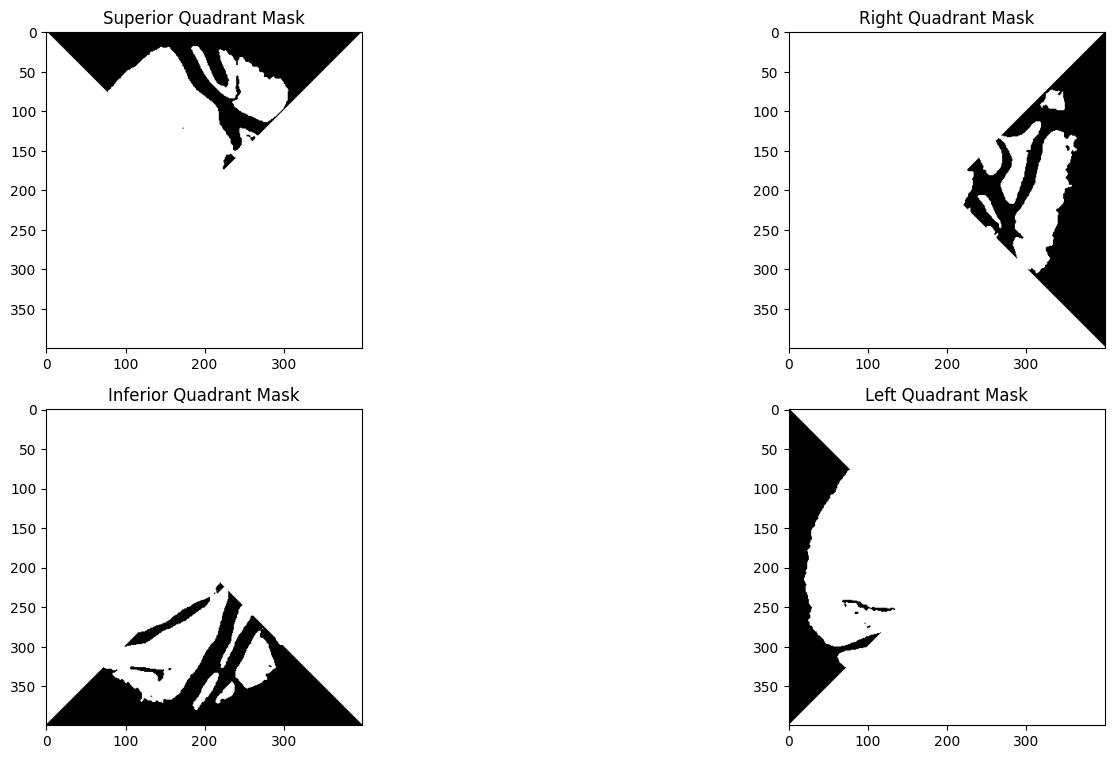

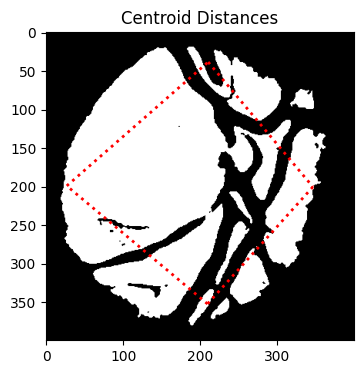

Centroid Distance Values:
211.64049887813863
204.56869779187377
238.57907262574122
244.12324764930537

Mean Distance:
224.72787923626476


In [24]:
# In this cell, we 
# - use hard-coded quadrant masks to divide image into quandrants with "x" shape
# - calculate vessel centroid for each quadrant
# - calculate distance between centroids as a feature
# (greater distance between centroids => thinned NRR => glaucoma is probable)

from skimage import draw
from skimage import img_as_float
import math
import statistics

def findCentroid(img):
    # Calculate centroid (vp = vessel pixel)
    vpTotal = 0
    vpX = 0
    vpY = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 0:
                vpTotal += 1
                vpX += i
                vpY += j

    return [(vpX / vpTotal), (vpY / vpTotal)]

right = binary_img.shape[0] - 1
bottom = binary_img.shape[1] - 1
topLeft = [0, 0]
bottomLeft = [0, bottom]
topRight = [right, 0]
bottomRight = [right, bottom]
midPoint = [int(right / 2), int(bottom / 2)]

plt.figure(figsize=(15, 15))

# 1st quadrant (superior)
polygon = draw.polygon((topLeft[1], midPoint[1], topRight[1], bottomRight[1], bottomLeft[1]), 
                       (topLeft[0], midPoint[0], topRight[0], bottomRight[0], bottomLeft[0]))
superior = binary_img.copy()
draw.set_color(superior, polygon, 1)
plt.subplot(4, 2, 1)
plt.title("Superior Quadrant Mask")
plt.imshow(superior, cmap="gray")

# 2nd quadrant (right)
polygon = draw.polygon((topRight[1], midPoint[1], bottomRight[1], bottomLeft[1], topLeft[1]), 
                       (topRight[0], midPoint[0], bottomRight[0], bottomLeft[0], topLeft[0]))
right = binary_img.copy()
draw.set_color(right, polygon, 1)
plt.subplot(4, 2, 2)
plt.title("Right Quadrant Mask")
plt.imshow(right, cmap="gray")

# 3rd quadrant (inferior)
polygon = draw.polygon((bottomRight[1], midPoint[1], bottomLeft[1], topLeft[1], topRight[1]), 
                       (bottomRight[0], midPoint[0], bottomLeft[0], topLeft[0], topRight[0]))
inferior = binary_img.copy()
draw.set_color(inferior, polygon, 1)
plt.subplot(4, 2, 3)
plt.title("Inferior Quadrant Mask")
plt.imshow(inferior, cmap="gray")

# 4th quadrant (left)
polygon = draw.polygon((bottomLeft[1], midPoint[1], topLeft[1], topRight[1], bottomRight[1]), 
                       (bottomLeft[0], midPoint[0], topLeft[0], topRight[0], bottomRight[0]))
left = binary_img.copy()
draw.set_color(left, polygon, 1)
plt.subplot(4, 2, 4)
plt.title("Left Quadrant Mask")
plt.imshow(left, cmap="gray")

plt.tight_layout()

# Find and show distances btwn centroids
centroid1 = findCentroid(superior)
centroid2 = findCentroid(right)
centroid3 = findCentroid(inferior)
centroid4 = findCentroid(left)
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plt.title("Centroid Distances")
plt.plot([centroid1[1], centroid2[1]], [centroid1[0], centroid2[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid2[1], centroid3[1]], [centroid2[0], centroid3[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid3[1], centroid4[1]], [centroid3[0], centroid4[0]], ls="dotted", color="red", linewidth=2)
plt.plot([centroid4[1], centroid1[1]], [centroid4[0], centroid1[0]], ls="dotted", color="red", linewidth=2)
plt.imshow(binary_img, cmap="gray")
plt.show()

# calculate and average the distances of centroids
distances = []
distances.append(math.dist(centroid1, centroid2))
distances.append(math.dist(centroid2, centroid3))
distances.append(math.dist(centroid3, centroid4))
distances.append(math.dist(centroid4, centroid1))
print("Centroid Distance Values:")
for d in distances:
    print(d)
print()
print("Mean Distance:")
print(statistics.mean(distances))

In [26]:
# Now, lets test our hypothesis that greater mean centroid distance indicates glaucoma using "X" shaped mask:
# 5 diseased eyes, 5 healthy eyes

from skimage import color, io, filters, morphology, exposure, draw, img_as_float, transform
import numpy as np
import cv2
import math
import statistics

# To minimize code, we can encapsulate what we have done inside a function to do it over and over
def meanCentroidDistanceFromRaw(imgSource):
    # Preprocessing / Vessel Segmentation
    img = io.imread(imgSource)
    img = transform.resize(img, (400, 400))
    gray_img = rgb2gray(img) # Convert RGB image to monochrome
    clahe_img = exposure.equalize_adapthist(gray_img) # Equalize contrast with CLAHE algorithm
    denoised_img = cv2.medianBlur(np.float32(clahe_img), 3) # Denoise image with the median blur filter
    threshold = filters.threshold_isodata(denoised_img) # obtain threshold with isodata algorithm
    binary_img = denoised_img > threshold # binarize image
    
    # Get Quadrant Mask Points
    right = binary_img.shape[0] - 1
    bottom = binary_img.shape[1] - 1
    corner1 = [0, 0]
    corner2 = [0, bottom]
    corner3 = [right, 0]
    corner4 = [right, bottom]
    midbottom = [int(right / 2), bottom]
    midtop = [int(right / 2), 0]
    midleft = [0, int(bottom / 2)]
    midright = [right, int(bottom / 2)]
    midpoint = [int(right / 2), int(bottom / 2)]

    # Quadrant Masks
    polygon = draw.polygon((topLeft[1], midPoint[1], topRight[1], bottomRight[1], bottomLeft[1]), 
                           (topLeft[0], midPoint[0], topRight[0], bottomRight[0], bottomLeft[0]))
    superior = binary_img.copy()
    draw.set_color(superior, polygon, 1)
    polygon = draw.polygon((topRight[1], midPoint[1], bottomRight[1], bottomLeft[1], topLeft[1]), 
                           (topRight[0], midPoint[0], bottomRight[0], bottomLeft[0], topLeft[0]))
    right = binary_img.copy()
    draw.set_color(right, polygon, 1)
    polygon = draw.polygon((bottomRight[1], midPoint[1], bottomLeft[1], topLeft[1], topRight[1]), 
                           (bottomRight[0], midPoint[0], bottomLeft[0], topLeft[0], topRight[0]))
    inferior = binary_img.copy()
    draw.set_color(inferior, polygon, 1)
    polygon = draw.polygon((bottomLeft[1], midPoint[1], topLeft[1], topRight[1], bottomRight[1]), 
                           (bottomLeft[0], midPoint[0], topLeft[0], topRight[0], bottomRight[0]))
    left = binary_img.copy()
    draw.set_color(left, polygon, 1)

    # Find centroids
    def findCentroid(img):
        # Calculate centroid (vp = vessel pixel)
        vpTotal = 0
        vpX = 0
        vpY = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    vpTotal += 1
                    vpX += i
                    vpY += j

        return [(vpX / vpTotal), (vpY / vpTotal)]
    
    centroid1 = findCentroid(superior)
    centroid2 = findCentroid(right)
    centroid3 = findCentroid(inferior)
    centroid4 = findCentroid(left)
    
#     plt.figure(figsize=(4, 4))
#     plt.subplot(1, 1, 1)
#     plt.title(imgSource + " Centroid Distances")
#     plt.plot([centroid1[1], centroid2[1]], [centroid2[0], centroid2[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid2[1], centroid3[1]], [centroid2[0], centroid3[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid3[1], centroid4[1]], [centroid3[0], centroid4[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid4[1], centroid1[1]], [centroid4[0], centroid1[0]], ls="dotted", color="red", linewidth=2)
#     plt.imshow(binary_img, cmap="gray")
#     plt.show()

    # Centroid Distance Calculation
    distances = []
    distances.append(math.dist(centroid1, centroid2))
    distances.append(math.dist(centroid2, centroid3))
    distances.append(math.dist(centroid3, centroid4))
    distances.append(math.dist(centroid4, centroid1))
    
    res = round(statistics.mean(distances), 3)
    print(res, end=", ")
    
    return res

imagesDiseased = []
imagesHealthy = []
for i in range(1, 6):
    imagesDiseased.append("diseased" + str(i) + ".png")
    imagesHealthy.append("healthy" + str(i) + ".png")
    
# Diseas

print('(Using "x" Shaped Quadrant Mask)')
print('Diseased eye average centroid distances:')
# Test diseased eyes
for img in imagesDiseased:
    meanCentroidDistanceFromRaw(img)

print("")
print('Healthy eye average centroid distances:')
# Test healthy eyes
for img in imagesHealthy:
    meanCentroidDistanceFromRaw(img)

(Using "x" Shaped Quadrant Mask)
Diseased eye average centroid distances:
222.63, 226.83, 215.431, 216.968, 224.728, 
Healthy eye average centroid distances:
219.921, 215.611, 215.803, 213.807, 214.65, 